In [2]:
import numpy as np
import biobox as bb
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Conv1D, GlobalMaxPooling1D
from keras.models import Model
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

np.random.seed(123)
# rn.seed(123)
tf.random.set_seed(1)

# infile = sys.argv[1]
encoding_dim = 3
BATCH_SIZE = 10
EPOCHS = 50

original_pdb_file = "/Users/claireleblanc/Downloads/structures/PED00016e001.pdb"
protein name = "PED00016e001"

/Users/claireleblanc/opt/anaconda3/envs/MD_v3/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Aligning structures for use in training
mobile = mda.Universe(original_pdb_file)
ref = mda.Universe(original_pdb_file)

mobile.trajectory[0]  
ref.trajectory[-1]
aligner = align.AlignTraj(ref, mobile, select='name CA', in_memory=True).run()

# change range to augment data with translations and rotations
for i in range(1):
    mobile.trajectory[-1]  
    ref.trajectory[i]  # Set to ith trajectory
    mobile_ca = mobile.select_atoms('name CA') # Depending on pdb file, may have to modify this
    ref_ca = ref.select_atoms('name CA')
    aligner = align.AlignTraj(mobile, ref, select='name CA', in_memory=True).run()
    curr_coors = [ts.positions for ts in mobile.trajectory]
    coords.append(curr_coors)

# Save coordinates for use in training
coords = np.array(coords)
coords = coords.reshape(coords.shape[0]*coords.shape[1],coords.shape[2],coords.shape[3])

# Save aligned stuctures
new_struct = mda.Universe(original_pdb_file, coords)
with mda.Writer(f"{protein_name}_orig_traj.pdb", multiframe=True) as W:
    for ts in new_struct.trajectory:
        W.write(new_struct)

/Users/claireleblanc/opt/anaconda3/envs/MD_v3/lib/python3.7/site-packages/MDAnalysis/coordinates/base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")
/Users/claireleblanc/opt/anaconda3/envs/MD_v3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


In [84]:
# Define the VAE architecture
def get_encoder(x_train):
    input_prot = Input(shape=(x_train.shape[1],))

    encoded = Dense(1024, activation='relu')(input_prot)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)

    encode_mean = Dense(encoding_dim)(encoded)
    encode_log_var = Dense(encoding_dim)(encoded)

    sample = Lambda(sampling, name='sampling')([encode_mean, encode_log_var])

    # encoder = Model(input_prot, sample)

    return input_prot, sample, encode_mean, encode_log_var

def get_decoder(sample, shape):
    # decoder
    decoded = Dense(16, activation='relu')(sample)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(1024, activation='relu')(decoded)
    decoded = Dense(shape, activation='sigmoid')(decoded)

    return decoded


def vae_structure(x_train):
    input_prot, sample, encode_mean, encode_log_var = get_encoder(x_train)

    decoded = get_decoder(sample, x_train.shape[1])

    sampling_model = Model(input_prot, decoded)

    # define loss
    mse = tf.keras.losses.MeanSquaredError()
    
    xent_loss = K.sum(mse(input_prot, decoded))
    kl_loss = -5e-5 * K.mean(1 + encode_log_var - K.square(encode_mean) - K.square(K.exp(encode_log_var)))
    
    diff_input = tf.expand_dims(input_prot, 0) - tf.expand_dims(input_prot, 1)
    diff_reconstructed = tf.expand_dims(decoded, 0) - tf.expand_dims(decoded, 1)
    input_dist = tf.sqrt(tf.reduce_sum(tf.square(diff_input), axis=-1))
    reconstructed_dist = tf.sqrt(tf.reduce_sum(tf.square(diff_reconstructed), axis=-1))
    distance_loss = 1e-5 * K.mean((tf.square(input_dist-reconstructed_dist)))
    
    vae_loss = xent_loss + kl_loss + distance_loss
    sampling_model.add_loss(vae_loss)

    sampling_model.compile(optimizer='rmsprop', metrics='mean_squared_error')
    K.set_value(sampling_model.optimizer.learning_rate, 0.00001)

    return sampling_model  

def sampling(arg):
    mean = arg[0]
    logvar = arg[1]
    epsilon = K.random_normal(shape=K.shape(mean), mean=0, stddev=1.)
    return mean + K.exp(logvar/2) * epsilon

In [85]:
# load data
x_reshaped = coords.reshape(coords.shape[0],-1)
x_train_orig = x_reshaped[:int(x_reshaped.shape[0]*.9),:]
x_test_orig = x_reshaped[int(x_reshaped.shape[0]*.9):,:]

# normalization of input data
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train_orig)
x_test = scaler.fit_transform(x_test_orig)

sampling_model = vae_structure(x_train)

# Train the model
history = sampling_model.fit(x_train, x_train,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                validation_data=(x_test, x_test))

Epoch 1/50
445/445 [==============================] - 43s 87ms/step - loss: 0.0248 - mean_squared_error: 0.0238 - val_loss: 0.0328 - val_mean_squared_error: 0.0314
Epoch 2/50
445/445 [==============================] - 46s 102ms/step - loss: 0.0229 - mean_squared_error: 0.0218 - val_loss: 0.0316 - val_mean_squared_error: 0.0304
Epoch 3/50
445/445 [==============================] - 48s 108ms/step - loss: 0.0223 - mean_squared_error: 0.0213 - val_loss: 0.0303 - val_mean_squared_error: 0.0290
Epoch 4/50
445/445 [==============================] - 50s 113ms/step - loss: 0.0209 - mean_squared_error: 0.0200 - val_loss: 0.0289 - val_mean_squared_error: 0.0278
Epoch 5/50
445/445 [==============================] - 48s 108ms/step - loss: 0.0202 - mean_squared_error: 0.0194 - val_loss: 0.0279 - val_mean_squared_error: 0.0269
Epoch 6/50
445/445 [==============================] - 63s 141ms/step - loss: 0.0196 - mean_squared_error: 0.0188 - val_loss: 0.0266 - val_mean_squared_error: 0.0256
Epoch 7/50


In [86]:
x_train = scaler.fit_transform(x_train_orig)
rc_train = sampling_model.predict(x_train)
reconstruct_train = scaler.inverse_transform(rc_train)
decoded_reshaped_train = reconstruct_train.reshape(reconstruct_train.shape[0],
                                                    int(reconstruct_train.shape[1] / 3), 3)

# Save the decoded coordinates as new structures
new_struct = mda.Universe("/Users/claireleblanc/Downloads/structures/PED00016e001.pdb",decoded_reshaped_train)
calphas = new_struct.select_atoms("name CA")
with mda.Writer(f"{protein_name}_reconstructed_traj.pdb", multiframe=True) as W:
    for ts in new_struct.trajectory:
        W.write(new_struct)

/Users/claireleblanc/opt/anaconda3/envs/MD_v3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


OSError: [Errno 28] No space left on device

In [87]:
restored_w = []
last_encoder_layer = 7
for w in sampling_model.layers[last_encoder_layer + 1:]:
    restored_w.extend(w.get_weights())

# reconstruct decoder architecture setting the fitted weights
new_inp = [Input(l.shape[1]) for l in get_encoder(x_train)]
new_dec = get_decoder(new_inp[1], x_train.shape[1])
decoder = Model(new_inp, new_dec)
decoder.set_weights(restored_w)

In [88]:
# Sample from normal to get latent dimension
latent_input = np.random.normal(0, 1, (5000, encoding_dim)).astype('float32')

# Filler input layers not used in actual model
additional_input_1 = np.random.normal(size=(5000, x_train.shape[1])) 
additional_input_2 = np.random.normal(size=(5000, encoding_dim))  
additional_input_3 = np.random.normal(size=(5000, encoding_dim))  

# Predict structures
pred_decoder = decoder.predict([additional_input_1, latent_input, additional_input_2, additional_input_3])
reconstruct_new = scaler.inverse_transform(pred_decoder)
reconstruct_new =  reconstruct_new.reshape(reconstruct_new.shape[0], int(reconstruct_new.shape[1] / 3), 3)

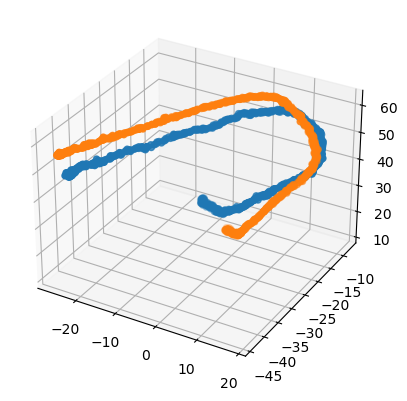

In [89]:
# Visualize some sample structures
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')
pos0 = reconstruct_new[0]
pos1 = reconstruct_new[-1]

x = pos0[:,0]
y =  pos0[:,1]
z = pos0[:,2]
ax.scatter(x, y, z)

x = pos1[:,0]
y =  pos1[:,1]
z = pos1[:,2]
ax.scatter(x, y, z)

# x = pos2[:,0]
# y =  pos2[:,1]
# z = pos2[:,2]
# # Scatter plot
# ax.scatter(x, y, z)

# Show the plot
plt.show()


In [ ]:
# Save the new structures
new_struct = mda.Universe("/Users/claireleblanc/Downloads/structures/PED00016e001.pdb",reconstruct_new)
calphas = new_struct.select_atoms("name CA")
with mda.Writer(f"{protein_name}_generated_traj.pdb", multiframe=True) as W:
    for ts in new_struct.trajectory:
        W.write(new_struct)

/Users/claireleblanc/opt/anaconda3/envs/MD_v3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
